In [367]:
import tensorflow as tf
import numpy as np
import os
import cv2
import time
import matplotlib.pyplot as plt
data_dir = "/home/olle/PycharmProjects/derive_depth_vector/data/L/13-10-22"
file_name = "seg_1.tif"
image_path = os.path.join(data_dir,file_name)
img = cv2.imread(image_path,0)

(496, 512)


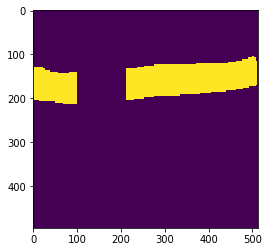

In [368]:
#create cases
print(img.shape)
#right
img_right = np.copy(img)
img_right[:,400:512]=0
#left
img_left = np.copy(img)
img_left[:,0:112]=0
#midddle
img_middle = np.copy(img)
img_middle[:,100:212]=0
plt.imshow(img_middle)

In [68]:
start = time.time()

top_array = np.zeros(img.shape[1])
bottom_array  = np.zeros(img.shape[1])

for i in range(0,img.shape[1]):
    for j in range(0, img.shape[0]):
        if img[j,i] == 255 and img[j-1,i] == 0:
            top = j
        if img[j,i] == 255 and img[j+1,i] == 0:
            bottom = j
        
    top_array[i] = top
    bottom_array[i] = bottom
    depth_vector = np.subtract(bottom_array, top_array)
end = time.time()
print(end - start)
    
            
        

0.698381185532


In [93]:
for i in range(0,img.shape[1]):
    top = np.nonzero(img[:,i])


In [102]:
 np.nonzero(img[:,-4])

(array([115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
        141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
        167, 168, 169, 170]),)

In [365]:
img_right

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [372]:
img = img_middle
def get_interpolated_depth_vector(img):
    def find_nearest_min(array, value):
        idx = (np.abs(array - value)).argmin()
        return idx

    def find_nearest_max(array, value):
        idx = (np.abs(array - value)).argmax()
        return idx

    def get_zero_patches(idx_zero):

        def split(arr, cond):
            return [arr[cond], arr[~cond]]

        diff_vector = np.zeros(1+idx_zero.shape[0])
        diff_vector[1:]= idx_zero
        differences = np.subtract(idx_zero, diff_vector[0:-1])[1:]
        indices = np.where(differences>1)
        #print(indices, differences)
        zero_patches = []

        if indices[0].size != 0:
            #extract first zero patch
            zero_patches.append(idx_zero[np.where(idx_zero <= idx_zero[indices[0][0]])])
            #extract the following zero patches
            for i in range(indices[0][:].shape[0],0,-1):
                zero_patches.append(idx_zero[np.where(idx_zero > idx_zero[indices[0][i-1]])])
        if indices[0].size == 0:
            zero_patches.append(idx_zero)
        return(zero_patches)

    start = time.time()

    depth_vector = np.zeros(img.shape[1])
    for i in range(0,img.shape[1]):
        layer = np.argwhere(img[:,i])
        if layer.size != 0:  
            depth_vector[i] = max(layer) - min(layer)
    #interpolation of missing deoth information
    #get all indices
    idx_nonzero = np.argwhere(depth_vector)
    idx_zero = np.where(depth_vector==0)[0]
    #print(min(idx_zero),max(idx_zero), idx_zero)

    #get list with seperate zero patches
    zero_patches = get_zero_patches(idx_zero)
    #print(zero_patches)
    #find interpolation value       
    for patch in zero_patches:
        #print(patch)
        closest_min = find_nearest_min(idx_nonzero, min(patch))
        closest_max = find_nearest_min(idx_nonzero, max(patch)) 
        #print(closest_min, closest_max)
        #print(depth_vector[idx_nonzero[closest_min]],depth_vector[idx_nonzero[closest_max]])
        interpolation = (depth_vector[idx_nonzero[closest_min]]+depth_vector[idx_nonzero[closest_max]])/2
        #print(interpolation)
        #interpolate
        depth_vector[patch] = interpolation

    end = time.time()
    print(end - start)
    return depth_vector
